In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.compat.v1 as tf
import random
import os
import time
import warnings

from scipy.io import loadmat
from scipy.stats import skew
from scipy.stats import gaussian_kde
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from datetime import timedelta
from tensorflow.python.client import device_lib
from tensorflow.compat.v1.keras.preprocessing import image
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.__version__

'1.15.5'

In [12]:
def test_gpu():
    tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
    # Create two tensors for gpu test.
    print(tf.add([1.0, 2.0], [3.0, 4.0])) 
 
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    
    # Return a list of devices we can use in the notebook.
    return [x.name for x in local_device_protos]
    
test_gpu(), get_available_devices()

tf.Tensor([4. 6.], shape=(2,), dtype=float32)


(None, ['/device:CPU:0', '/device:DML:0'])

In [123]:
def get_data(dir_):
    # Load .mat data from current dir.
    svhn = loadmat(dir_)
    
    return svhn['X'], svhn['y']

def shape_data(X_train, y_train, X_test, y_test):
    # Exemple: X_train shape is (height, width, rgb, data_lenght) = (32, 32, 3, 73257).
    # After calling shape_data function X_train will be shape (data_lenght, height, width, rgb).
    X_train, y_train = X_train.transpose((3, 0, 1, 2)), y_train[:, 0]
    X_test, y_test = X_test.transpose((3, 0, 1, 2)), y_test[:, 0]
    
    return X_train, y_train, X_test, y_test

def loading_data():
    X_train, y_train = get_data('train_32x32.mat')
    X_test, y_test = get_data('test_32x32.mat')
    X_train, y_train,  X_test, y_test = shape_data(X_train, y_train, X_test, y_test)
    
    return X_train, y_train, X_test, y_test

In [124]:
X_train, y_train, X_test, y_test = loading_data()

In [125]:
def random_values():
    # Generate random values from 1 to 5000 to plot data.
    return random.randint(1, 5000)

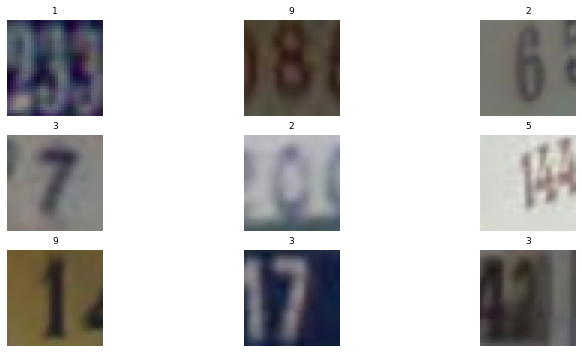

In [126]:
def data_view(data, output_values, rows, columns):
    fig, axs = plt.subplots(rows, columns, sharex=True, figsize=(rows * 4, columns * 2))
    
    for iter_, img in enumerate(axs.flat):
        img.imshow(data[random_values()])
        img.set_title(output_values[iter_], fontsize=9)
        img.axis('off')
        
data_view(X_train, y_train, 3, 3)

In [127]:
def skewness_check(output_values):
    # CHecking the data distribuition.
    print(skew(output_values))
    print(skew(output_values, bias=False))

In [128]:
print('Before data underweight\n')
skewness_check(y_train)

Before data underweight

0.4362057349038243
0.4362146668246221


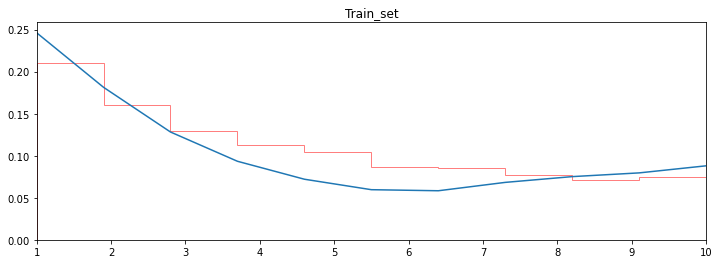

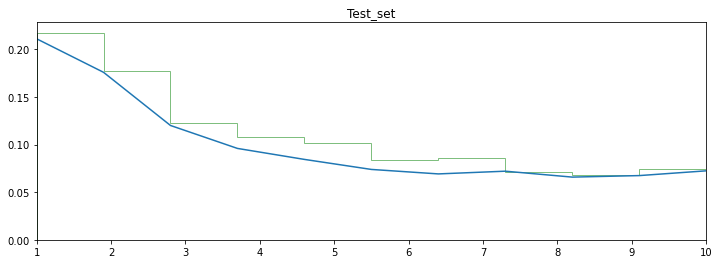

In [131]:
def distribution_view(rows, columns, output_values, bins, name, color, alpha):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(rows * 3, columns))
    density = gaussian_kde(output_values)
    n, x, _ = ax.hist(output_values, bins=bins, color=color, alpha=alpha, density=True, histtype=u'step')
    plt.plot(x, density(x))
    
    ax.set_title('Train_set', fontsize=12) if name == 'y_train' else ax.set_title('Test_set', fontsize=12)
    ax.set_xlim(1, 10)
    
    plt.show()
    
distribution_view(4, 4, y_train, 10, 'y_train', 'red', 0.5)
distribution_view(4, 4, y_test, 10, 'y_test', 'green', 0.5)

In [132]:
def data_underweight(output_values):
    # Deleting the values == 10 from output_values -> make it skew positive.
    output_values[output_values == 10] = 0

    return output_values

y_train = data_underweight(y_train)
y_test = data_underweight(y_test)

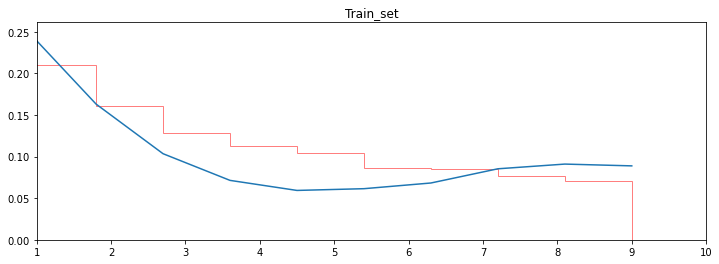

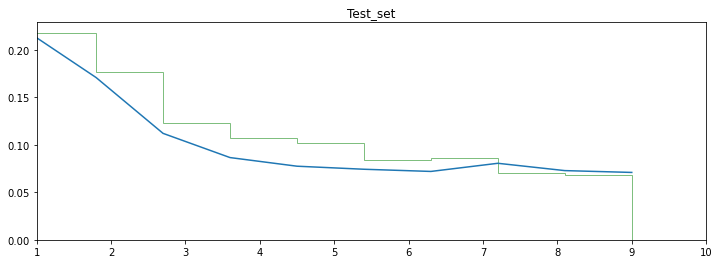

In [133]:
distribution_view(4, 4, y_train, 10, 'y_train', 'red', 0.5)
distribution_view(4, 4, y_test, 10, 'y_test', 'green', 0.5)